## Proyecto Final

### Integrantes
### Oziel Imanol Lemus Montelongo
### Daniel Isaí Saldaña Rocha
### Guillermo Gonzalo Veyro Ramos

## Modelo Estrella

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('./vgsales.csv')

genre_sales = data.groupby('Genre')['Global_Sales'].sum().sort_values(ascending=False)

platform_sales = data.groupby('Platform')['Global_Sales'].sum().sort_values(ascending=False)

publisher_sales = data.groupby('Publisher')['Global_Sales'].sum().sort_values(ascending=False)

top_genres = genre_sales.head(5)
top_platforms = platform_sales.head(5)
top_publishers = publisher_sales.head(5)

print("Top 5 Géneros por Ventas Globales:")
print(top_genres)
print("\nTop 5 Plataformas por Ventas Globales:")
print(top_platforms)
print("\nTop 5 Publicadoras por Ventas Globales:")
print(top_publishers)


Top 5 Géneros por Ventas Globales:
Genre
Action          563.00
Shooter         487.12
Platform        433.80
Role-Playing    398.94
Sports          395.72
Name: Global_Sales, dtype: float64

Top 5 Plataformas por Ventas Globales:
Platform
Wii     444.46
X360    391.59
PS2     390.45
PS3     333.88
DS      312.75
Name: Global_Sales, dtype: float64

Top 5 Publicadoras por Ventas Globales:
Publisher
Nintendo                       1313.27
Activision                      304.95
Electronic Arts                 291.30
Sony Computer Entertainment     275.49
Take-Two Interactive            191.24
Name: Global_Sales, dtype: float64


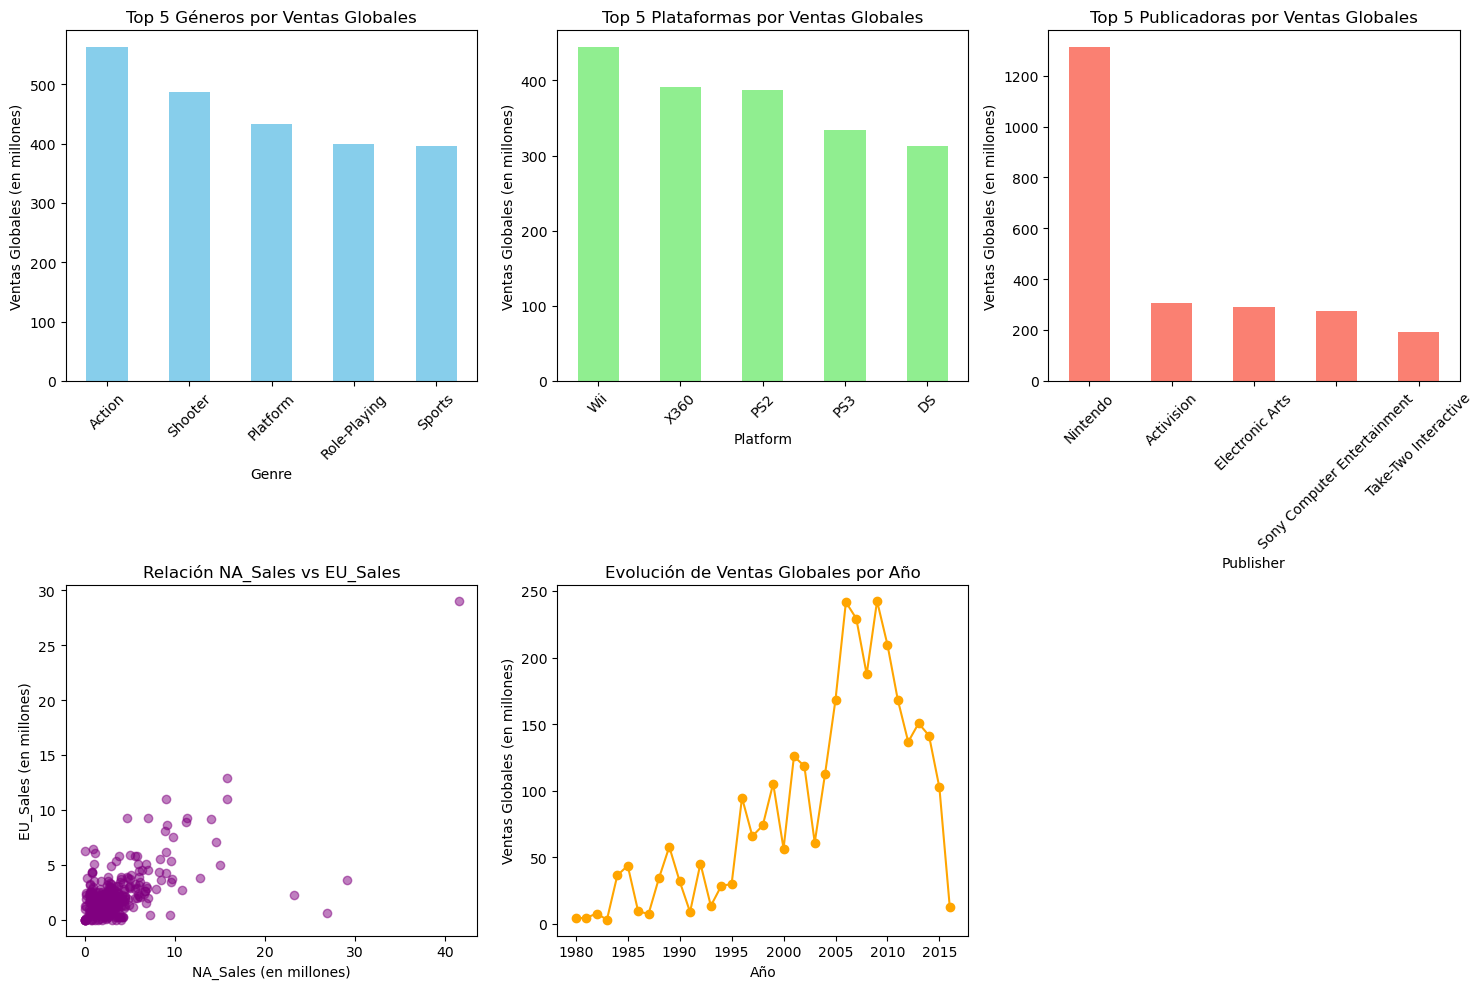

In [2]:
# Limpieza de datos
# Eliminar duplicados
data = data.drop_duplicates()

# Manejo de valores faltantes
data['Year'] = data['Year'].fillna(data['Year'].median()) 
data = data.dropna(subset=['Publisher'])

# Conversión de tipos
data['Year'] = data['Year'].astype(int)

# Gráficos exploratorios
plt.figure(figsize=(15, 10))

# Gráfico 1: Top 5 Géneros por Ventas Globales
genre_sales = data.groupby('Genre')['Global_Sales'].sum().sort_values(ascending=False).head(5)
plt.subplot(2, 3, 1)
genre_sales.plot(kind='bar', color='skyblue')
plt.title('Top 5 Géneros por Ventas Globales')
plt.ylabel('Ventas Globales (en millones)')
plt.xticks(rotation=45)

# Gráfico 2: Top 5 Plataformas por Ventas Globales
platform_sales = data.groupby('Platform')['Global_Sales'].sum().sort_values(ascending=False).head(5)
plt.subplot(2, 3, 2)
platform_sales.plot(kind='bar', color='lightgreen')
plt.title('Top 5 Plataformas por Ventas Globales')
plt.ylabel('Ventas Globales (en millones)')
plt.xticks(rotation=45)

# Gráfico 3: Top 5 Publicadoras por Ventas Globales
publisher_sales = data.groupby('Publisher')['Global_Sales'].sum().sort_values(ascending=False).head(5)
plt.subplot(2, 3, 3)
publisher_sales.plot(kind='bar', color='salmon')
plt.title('Top 5 Publicadoras por Ventas Globales')
plt.ylabel('Ventas Globales (en millones)')
plt.xticks(rotation=45)

# Gráfico 4: Relación entre NA_Sales y EU_Sales
plt.subplot(2, 3, 4)
plt.scatter(data['NA_Sales'], data['EU_Sales'], alpha=0.5, color='purple')
plt.title('Relación NA_Sales vs EU_Sales')
plt.xlabel('NA_Sales (en millones)')
plt.ylabel('EU_Sales (en millones)')

# Gráfico 5: Evolución de Ventas Globales por Año
sales_by_year = data.groupby('Year')['Global_Sales'].sum()
plt.subplot(2, 3, 5)
sales_by_year.plot(kind='line', color='orange', marker='o')
plt.title('Evolución de Ventas Globales por Año')
plt.xlabel('Año')
plt.ylabel('Ventas Globales (en millones)')

plt.tight_layout()
plt.show()

In [6]:
import pandas as pd
import psycopg2


# Manejo de valores faltantes
data['Year'] = data['Year'].fillna(data['Year'].median())  
data = data.dropna(subset=['Publisher'])

# Conversión de tipos
data['Year'] = data['Year'].astype(int)

cuantitativas = data.select_dtypes(include=['int64', 'float64'])
cualitativas = data.select_dtypes(include=['object'])

# Conexión a PostgreSQL
try:
    conn = psycopg2.connect(
        user="postgres",
        password="root",
        host="localhost",
        port="5432",
        database="DbVideogamesSales"
    )
    print("Conexión exitosa a la base de datos")
except Exception as e:
    print(f"Error al conectar a la base de datos: {e}")
    exit()

# Crear cursor
cur = conn.cursor()

def crear_tabla(df, nombre_tabla, cur, conn):
    """Crea una tabla en la base de datos PostgreSQL a partir de un DataFrame."""
    dtype_mapping = {
        'object': 'TEXT',
        'int64': 'INT',
        'float64': 'FLOAT',
        'bool': 'BOOLEAN'
    }

    columns = []
    for col, dtype in zip(df.columns, df.dtypes):
        pg_type = dtype_mapping.get(str(dtype), 'TEXT')
        columns.append(f"{col} {pg_type}")

    columns_sql = ", ".join(columns)
    SQLQuery = f"CREATE TABLE IF NOT EXISTS {nombre_tabla} ({columns_sql});"
    try:
        cur.execute(SQLQuery)
        conn.commit()
        print(f"Tabla '{nombre_tabla}' creada correctamente.")
    except Exception as e:
        print(f"Error al crear la tabla '{nombre_tabla}': {e}")

def insertar_datos(df, nombre_tabla, cur, conn):
    """Inserta datos en una tabla de PostgreSQL a partir de un DataFrame."""
    df = df.where(pd.notnull(df), None)  # Reemplazar NaN por None
    columns = df.columns.tolist()
    values_template = ", ".join(["%s"] * len(columns))
    insert_query = f"INSERT INTO {nombre_tabla} ({', '.join(columns)}) VALUES ({values_template}) ON CONFLICT DO NOTHING;"

    values = [tuple(row) for row in df.to_numpy()]

    try:
        cur.executemany(insert_query, values)
        conn.commit()
        print(f"Datos insertados correctamente en la tabla '{nombre_tabla}'.")
    except Exception as e:
        conn.rollback()
        print(f"Error al insertar datos en la tabla '{nombre_tabla}': {e}")

# Crear tablas para datos cuantitativos y cualitativos
crear_tabla(cuantitativas, 'cuantitativas', cur, conn)
crear_tabla(cualitativas, 'cualitativas', cur, conn)

# Insertar datos en las tablas
insertar_datos(cuantitativas, 'cuantitativas', cur, conn)
insertar_datos(cualitativas, 'cualitativas', cur, conn)

# Conexión a la base de datos del data warehouse
dwh_conn = None
try:
    dwh_conn = psycopg2.connect(
        user="postgres",
        password="root",
        host="localhost",
        port="5432",
        database="dwhissc712"
    )
    print("Conexión exitosa al data warehouse")
except Exception as e:
    print(f"Error al conectar al data warehouse: {e}")
    exit()

dwh_cur = dwh_conn.cursor()

# Crear dimensiones y tabla de hechos en el data warehouse
# Dimensiones
platform_dimension = data[['Platform']].drop_duplicates().reset_index(drop=True)
platform_dimension['PlatformID'] = platform_dimension.index + 1
crear_tabla(platform_dimension, 'dim_platform', dwh_cur, dwh_conn)
insertar_datos(platform_dimension, 'dim_platform', dwh_cur, dwh_conn)

genre_dimension = data[['Genre']].drop_duplicates().reset_index(drop=True)
genre_dimension['GenreID'] = genre_dimension.index + 1
crear_tabla(genre_dimension, 'dim_genre', dwh_cur, dwh_conn)
insertar_datos(genre_dimension, 'dim_genre', dwh_cur, dwh_conn)

# Tabla de hechos
fact_table = data.merge(platform_dimension, on='Platform').merge(genre_dimension, on='Genre')
fact_table = fact_table[['PlatformID', 'GenreID', 'Year', 'Global_Sales']]
crear_tabla(fact_table, 'fact_sales', dwh_cur, dwh_conn)
insertar_datos(fact_table, 'fact_sales', dwh_cur, dwh_conn)

# Cerrar conexiones
cur.close()
conn.close()
dwh_cur.close()
dwh_conn.close()


Conexión exitosa a la base de datos
Tabla 'cuantitativas' creada correctamente.
Tabla 'cualitativas' creada correctamente.
Datos insertados correctamente en la tabla 'cuantitativas'.
Datos insertados correctamente en la tabla 'cualitativas'.


# 2do Parcial
## Analisis de clustering con k-means

In [49]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [50]:
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['VECLIB_MAXIMUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'

In [51]:
df_kmeans = data[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']]

df_kmeans.head()

,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,41.49,29.02,3.77,8.46,82.74
1,29.08,3.58,6.81,0.77,40.24
2,15.85,12.88,3.79,3.31,35.82
3,15.75,11.01,3.28,2.96,33.00
4,11.27,8.89,10.22,1.00,31.37


In [52]:
scaler = StandardScaler()
datos_escalados = scaler.fit_transform(df_kmeans)

In [53]:
pca = PCA(n_components=5)
componentes_pca = pca.fit_transform(datos_escalados)

In [54]:
variacion_explicada = pca.explained_variance_ratio_

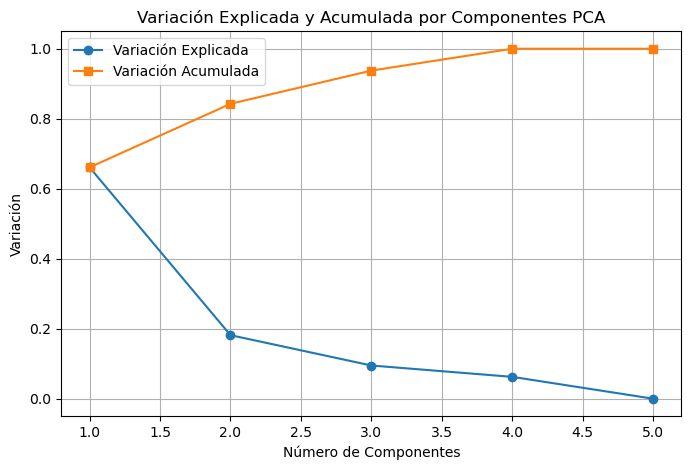

In [55]:
variacion_acumulada = np.cumsum(variacion_explicada)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(variacion_explicada) + 1), variacion_explicada, marker='o', label='Variación Explicada')
plt.plot(range(1, len(variacion_acumulada) + 1), variacion_acumulada, marker='s', label='Variación Acumulada')

plt.xlabel('Número de Componentes')
plt.ylabel('Variación')
plt.title('Variación Explicada y Acumulada por Componentes PCA')
plt.legend()
plt.grid(True)

plt.show()

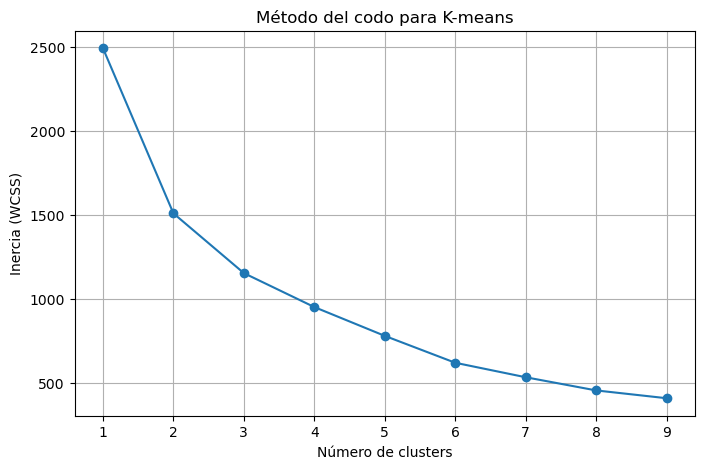

In [56]:
wcss = []

for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(componentes_pca)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 10), wcss, marker='o')
plt.title('Método del codo para K-means')
plt.xlabel('Número de clusters')
plt.ylabel('Inercia (WCSS)')
plt.grid(True)
plt.show()

/var/folders/8y/n92rcsqx2p14tk1dv66z141c0000gn/T/ipykernel_11010/2539268733.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_kmeans['Cluster'] = cluster_kmeans


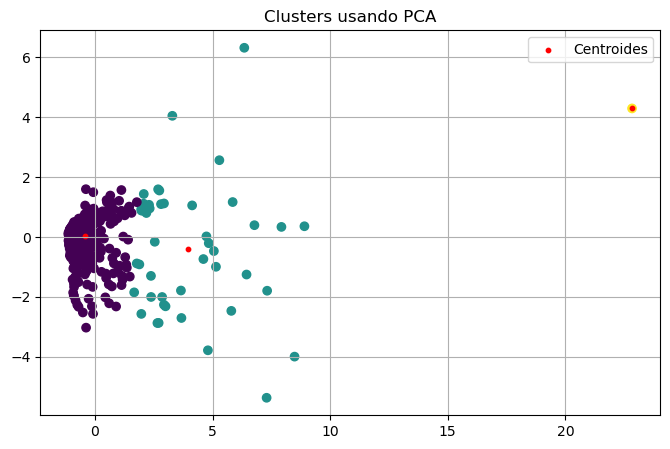

In [59]:
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42, n_init=10)
cluster_kmeans = kmeans.fit_predict(componentes_pca)

df_kmeans['Cluster'] = cluster_kmeans

plt.figure(figsize=(8, 5))
plt.scatter(componentes_pca[:, 0], componentes_pca[:, 1], c=df_kmeans['Cluster'], cmap='viridis', marker='o')

centroides = kmeans.cluster_centers_
plt.scatter(centroides[:, 0], centroides[:, 1], s=10, c='red', marker='o', label='Centroides')

plt.title('Clusters usando PCA')
plt.legend()
plt.grid(True)
plt.show()